In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import requests as r


import lightgbm as lgb
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import OrdinalEncoder
import shap

In [6]:
data = pd.read_csv('top_hearthstone_decks_20200221.csv')

In [7]:
cat = ['card_0', 'card_1', 'card_2', 'card_3', 'card_4', 'card_5', 'card_6',
       'card_7', 'card_8', 'card_9', 'card_10', 'card_11', 'card_12',
       'card_13', 'card_14', 'card_15', 'card_16', 'card_17', 'card_18',
       'card_19', 'card_20', 'card_21', 'card_22', 'card_23', 'card_24',
       'card_25', 'card_26', 'card_27', 'card_28', 'card_29', 'hero']

# get all categories

categories = np.array(data[cat].values.reshape(736*31))

# drop na
categories = categories[~pd.isnull(categories)]

# drop duplicates
categories = np.unique(categories)

In [9]:
cards_df = pd.DataFrame(columns=categories, index = data.index)

for i in data.index:
    #print('deck ', i,' from ', len(data))
    cards_df.loc[i,data.loc[i,cat].dropna().values] = 1

cards_df.fillna(0, inplace = True)

In [34]:
response = r.get('https://api.hearthstonejson.com/v1/68600/enUS/cards.json'
                 ,verify = False)

cards_info = pd.read_json(response.content)

Unverified HTTPS request is being made to host 'api.hearthstonejson.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


In [35]:
# some adjustments for the data

cards_info['neutral_class'] = cards_info.cardClass.apply(lambda x: 1 if x == 'NEUTRAL' else 0)

cards_info = cards_info.astype({'name':'category', 'type':'category'})

# putting some mechanics in separate columns

mechanics = ['BATTLECRY','DEATHRATTLE','TAUNT','AURA','SECRET','DISCOVER','RUSH']

for mech in mechanics:
    cards_info[mech] = cards_info.mechanics.dropna().apply(lambda x: np.isin(x,mech)[0])

cards_info[mechanics] = cards_info[mechanics].fillna(False)*1

In [36]:
cards_info = cards_info.loc[cards_info.name.isin(cards_df.columns)
                            ,['cardClass','attack', 'neutral_class', 'cost', 'health',
                               'name', 'type','spellDamage', 'BATTLECRY','DEATHRATTLE','TAUNT','AURA'
                              ,'SECRET','DISCOVER','RUSH']]

cards_info.head()

,cardClass,attack,neutral_class,cost,health,name,type,spellDamage,BATTLECRY,DEATHRATTLE,TAUNT,AURA,SECRET,DISCOVER,RUSH
241,NEUTRAL,NaN,1,NaN,NaN,Rampage,ENCHANTMENT,NaN,0,0,0,0,0,0,0
399,NEUTRAL,1.0,1,1.0,1.0,Skaterbot,MINION,NaN,0,0,0,0,0,0,0
400,NEUTRAL,NaN,1,NaN,NaN,Skaterbot,ENCHANTMENT,NaN,0,0,0,0,0,0,0
404,HUNTER,NaN,0,2.0,NaN,Bomb Toss,SPELL,NaN,0,0,0,0,0,0,0
405,HUNTER,5.0,0,7.0,5.0,Boommaster Flark,MINION,NaN,1,0,0,0,0,0,0


In [46]:
#data.hero.


241                  Rampage
399                Skaterbot
417         Mechanical Whelp
439         Missile Launcher
441              Omega Medic
                ...         
10680            Hailbringer
10682    Licensed Adventurer
10683       Frenzied Felwing
10685       Boompistol Bully
10687      Grand Lackey Erkh
Name: name, Length: 240, dtype: category
Categories (8027, object): ["Armor Up", "Confiscated" Goods, "Gnomebliterator", "Kind" Waitress, ..., Zuramat the Obliterator, Zwick, Zzeraku the Warped, [TEMP]]

In [37]:
# some cards will be duplicated as they may have different attributes in different circumstanses. We only keep one variant of a card

cards_info = cards_info.loc[~cards_info.duplicated(subset = ['name'], keep='first')]


In [51]:
cards_info[cards_info.name=='Murmy']

,cardClass,attack,neutral_class,cost,health,name,type,spellDamage,BATTLECRY,DEATHRATTLE,TAUNT,AURA,SECRET,DISCOVER,RUSH
9799,NEUTRAL,1.0,1,1.0,1.0,Murmy,MINION,NaN,0,0,0,0,0,0,0


In [140]:
def add_meta_to_deck(deck):
    
    card_mask = deck

    # number of cards with BATTLECRY	DEATHRATTLE	TAUNT	AURA	SECRET	DISCOVER	RUSH
    meta_data = cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),['BATTLECRY','DEATHRATTLE','TAUNT',
                                                    'AURA','SECRET','DISCOVER','RUSH']].sum()

    #costs of cards
#    costs = cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),'cost'].value_counts()
#    costs.index = ['cost_'+str(int(i)) for i in costs.index]

    costs = pd.DataFrame(index=[i for i in range(11)])
    costs[0] = cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),'cost'].value_counts()
    costs.index = ['cost_'+str(int(i)) for i in costs.index]

    costs[0] = costs[0].fillna(0)

    meta_data = meta_data.append(costs)

    #types of cards
    card_types = pd.DataFrame(cards_info.loc[cards_info.name.isin(card_mask[card_mask.values>0].index),'type'].value_counts(), columns=[0])
#    print(pd.DataFrame(card_types))
#    print(meta_data)

    meta_data = meta_data.append(card_types)

    return deck.append(meta_data)

In [141]:
add_meta_to_deck(cards_df.loc[10])

,0
A New Challenger...,0.0
Abusive Sergeant,0.0
Abyssal Summoner,0.0
Acidic Swamp Ooze,0.0
Acolyte of Pain,0.0
...,...
cost_6,2.0
cost_7,1.0
cost_8,0.0
cost_9,0.0


In [142]:
cards_df_meta = pd.DataFrame(add_meta_to_deck(cards_df.loc[0]))

for i in cards_df.index:
    
    cards_df_meta[i] = add_meta_to_deck(cards_df.loc[i])

cards_df_meta

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,0,1,2,3,4,5,6,7,8,9,...,726,727,728,729,730,731,732,733,734,735
A New Challenger...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0
Abusive Sergeant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
Abyssal Summoner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
Acidic Swamp Ooze,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
Acolyte of Pain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cost_6,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2,0.0,0.0
cost_7,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,2.0,0.0,2.0,1.0,2.0,3,0.0,2.0
cost_8,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,2.0
cost_9,3.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2,1.0,1.0


In [143]:
X, y = cards_df_meta.T, data['wr']

In [152]:
for i in X.columns:
    X[i] = X[i].astype('int16')

In [153]:
# Splitting 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 100, seed = 123) 
  
# Fitting the model 
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_X) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.022961


In [158]:
#xgb_r.save_model('xgb_r_model_decks_with_meta.json')
pickle.dump(xgb_r, open("xgb_r_model_decks_with_meta.pickle.dat", "wb"))
loaded_model = pickle.load(open("xgb_r_model_decks_with_meta.pickle.dat", "rb"))
loaded_pred = loaded_model.predict(test_X)

# RMSE Computation 
rmse = np.sqrt(MSE(test_y, loaded_pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.022961


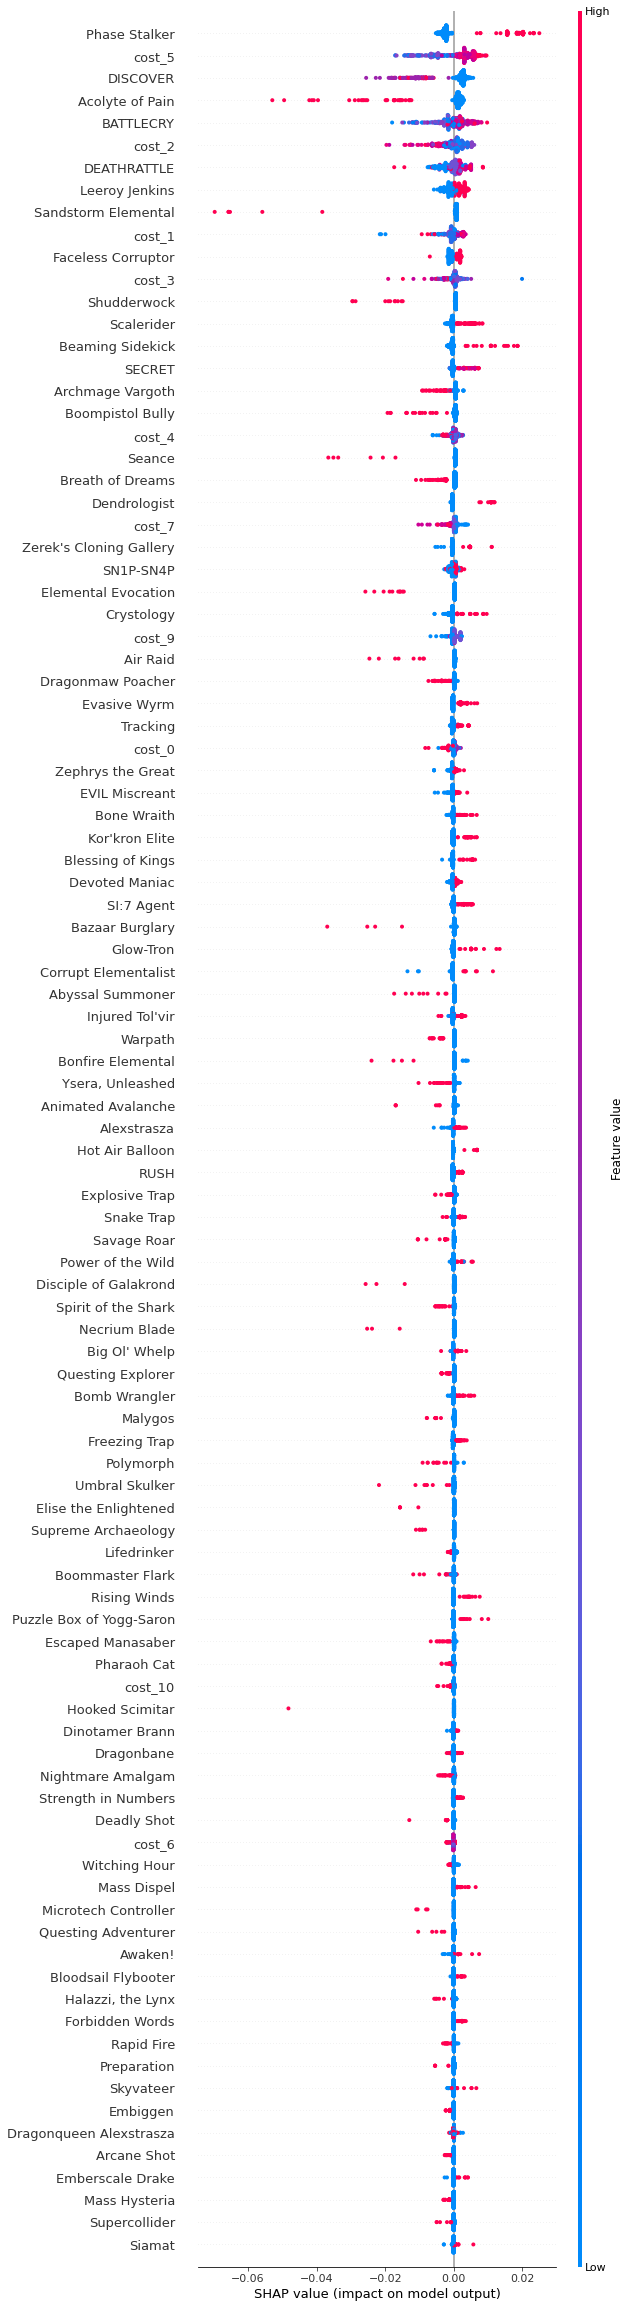

In [162]:
# SHAP features
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(train_X)

# summarize the effects of all the features
shap.summary_plot(shap_values, train_X, max_display=100)

In [177]:
shap.force_plot(explainer.expected_value, shap_values[0], test_X.iloc[0])

In [173]:
shap_values[0].shape, test_X.iloc[0].shape

((698,), (698,))

In [176]:
explainer.expected_value

0.5412631

In [180]:
cards_info['cardClass'].unique()

array(['NEUTRAL', 'HUNTER', 'WARRIOR', 'MAGE', 'PRIEST', 'WARLOCK',
       'PALADIN', 'ROGUE', 'SHAMAN', 'DRUID'], dtype=object)